<a href="https://colab.research.google.com/github/pierrelouisbescond/medium_articles/blob/main/XAI_Winter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###### *PEP8 CHECKED*

In [ ]:
import os
os.chdir("/content/drive/My Drive/Medium/XAI_Winter")

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
import glob
from IPython.display import display, clear_output
from IPython.display import Image as ImgDisplay

from PIL import Image

# From video to frames

In [ ]:
vidcap = cv2.VideoCapture('./01_video_source/from_autumn_to_winter_timelapse.mp4')

def getFrame(sec, count):
  vidcap.set(cv2.CAP_PROP_POS_MSEC, sec*1000)
  hasFrames, image = vidcap.read()
  if hasFrames:
    cv2.imwrite("./02_extracted_frames/image" + str(count).zfill(3) + ".jpg", image)
  return hasFrames

frameRate = 0.2 # capture one image in each x seconds

count = 0
sec = 0
success = True

while success:
    count += 1
    sec = round(sec + frameRate, 2)
    success = getFrame(sec, count)


## From classified frames to arrays

In [ ]:
def how_many_files_in_folder(path):
    files = glob.glob(path)
    nb_files = len(files)
    return nb_files, files

folders = ["0_no_or_light_snow", "1_snow_sunny", "2_snow_cloudy"]
nb_files_total = 0

for folder in folders:
    path = "./03_classified_frames/"+folder+"/*.jpg"
    nb_files, files = how_many_files_in_folder(path)
    nb_files_total += nb_files
    print("Number of files in "+folder+":", nb_files)

print("Total Number of files:", nb_files_total)


Number of files in 0_no_or_light_snow: 114
Number of files in 1_snow_sunny: 118
Number of files in 2_snow_cloudy: 139
Total Number of files: 371


In [ ]:
def img_to_data(path):

    img = Image.open(path)
    img.load()
    img = img.resize((260, 180))
    data = np.asarray(img, dtype="int32")

    return data


(180, 260, 3)


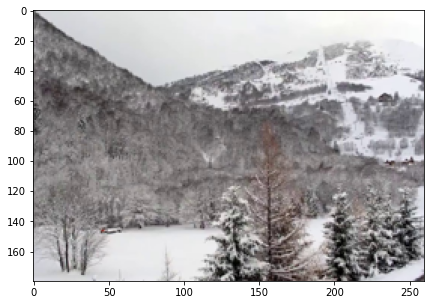

In [ ]:
img_sample = img_to_data(files[0])
print(img_sample.shape)

picture_y = img_sample.shape[0]
picture_x = img_sample.shape[1]

plt.figure(figsize=(7, 10))
plt.imshow(img_sample)
plt.show()


In [ ]:
data_collect_RGB = np.ndarray(shape=(nb_files_total, picture_y, picture_x, 3), dtype=int)
target_collect = np.ndarray(shape=(nb_files_total, 1), dtype=int)

print(data_collect_RGB.shape)
print(target_collect.shape)


(371, 180, 260, 3)
(371, 1)


In [ ]:
idx = 0

for folder in folders:
    path = "./03_classified_frames/"+folder+"/*.jpg"

    nb_files, files = how_many_files_in_folder(path)
    current_target = folder[0]

    for img in files:

        print(img)
        data_collect_RGB[idx] = img_to_data(img)
        target_collect[idx] = current_target
        clear_output(wait=True)

        idx += 1

print ("All pictures converted!")


All pictures converted!


In [ ]:
np.save('./04_classified_arrays/data_collect_RGB.npy', data_collect_RGB)
np.save('./04_classified_arrays/target_collect.npy', target_collect)


# From arrays to a deep-learning model

In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Activation

from sklearn.model_selection import train_test_split


In [ ]:
data_collect_RGB = np.load('./04_classified_arrays/data_collect_RGB.npy')
print(data_collect_RGB.shape)
target_collect = np.load('./04_classified_arrays/target_collect.npy')
print(target_collect.shape)
num_classes = len(np.unique(target_collect))
print("num_classes:", num_classes)


(371, 180, 260, 3)
(371, 1)
num_classes: 3


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(data_collect_RGB, target_collect, random_state=22)

In [ ]:
model = tf.keras.Sequential([
    Flatten(input_shape=(X_train.shape[1], X_train.shape[2], 3)),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes),
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(X_train, y_train,
          epochs=100,
          validation_data=(X_valid, y_valid),
          );


Epoch 1/100
9/9 [==============================] - 3s 79ms/step - loss: 11454.3315 - accuracy: 0.3535 - val_loss: 3925.0679 - val_accuracy: 0.4731
Epoch 2/100
9/9 [==============================] - 0s 35ms/step - loss: 2903.3585 - accuracy: 0.5199 - val_loss: 126.0083 - val_accuracy: 0.8602
Epoch 3/100
9/9 [==============================] - 0s 35ms/step - loss: 620.6109 - accuracy: 0.7769 - val_loss: 1102.9664 - val_accuracy: 0.5699
Epoch 4/100
9/9 [==============================] - 0s 32ms/step - loss: 553.0244 - accuracy: 0.7901 - val_loss: 253.5880 - val_accuracy: 0.8710
Epoch 5/100
9/9 [==============================] - 0s 33ms/step - loss: 150.6074 - accuracy: 0.9257 - val_loss: 136.4506 - val_accuracy: 0.8817
Epoch 6/100
9/9 [==============================] - 0s 33ms/step - loss: 214.8445 - accuracy: 0.8880 - val_loss: 1104.9783 - val_accuracy: 0.6667
Epoch 7/100
9/9 [==============================] - 0s 34ms/step - loss: 230.4769 - accuracy: 0.9074 - val_loss: 84.3691 - val_accu

# From predictions to understanding

In [ ]:
def plot_figures(figures, nrows = 1, ncols=1):
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind, title in enumerate(figures):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    fig.set_figheight(10)
    fig.set_figwidth(20)


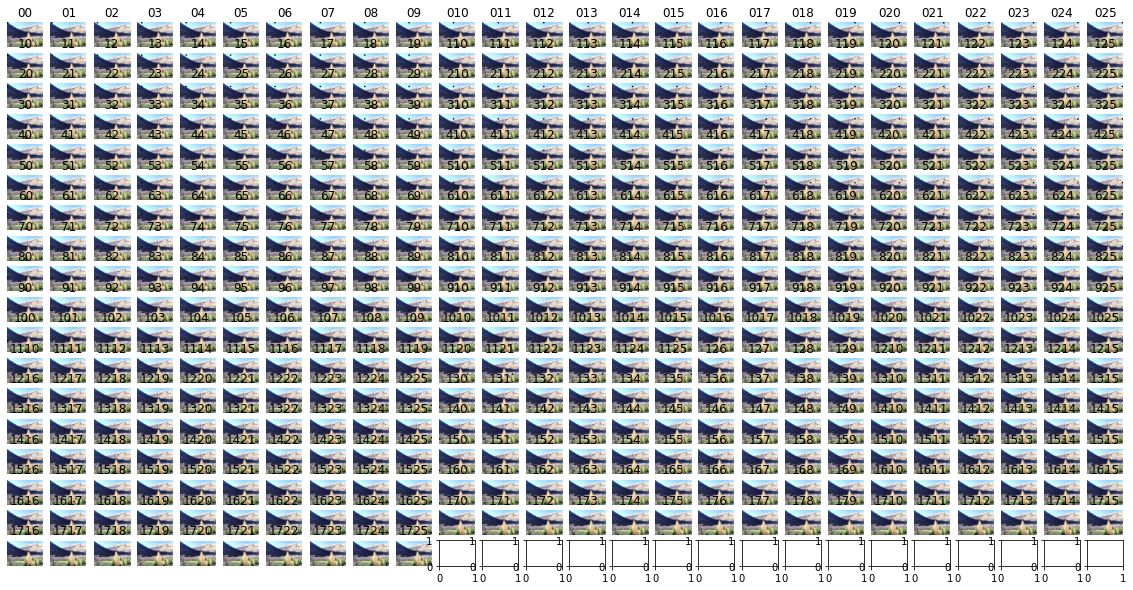

In [ ]:
img_original = X_valid[6].astype(np.uint8) #0_no_or_light_snow
#img_original = X_valid[7].astype(np.uint8) #1_snow_sunny
#img_original = X_valid[1].astype(np.uint8)#2_snow_cloudy

# We create a dictionnary to store the black-boxed pictures
img_to_show = {}

# We define the size of the black boxes applied on the original picture
step = 10
# and the corresponding number of step to run on the picture
step_nb_x = math.ceil(img_original.shape[1] / step)
step_nb_y = math.ceil(img_original.shape[0] / step)

for step_y in range(step_nb_y):
  for step_x in range(step_nb_x):
    
    # At every step, we create a new img_spl_black array
    # to avoid array_A = array_B reversability
    img_spl_black = img_original.copy()
  
    # We apply "0" (= black) on the black box location
    img_spl_black[step_y * step:step_y * step + step, step_x * step:step_x * step + step] = 0
    
    # We create an index (xy) to store the corresponding array
    idx = str(step_y)+str(step_x)
    img_to_show[idx] = img_spl_black

plot_figures(img_to_show, step_nb_y, step_nb_x)


In [ ]:
error_logs = pd.DataFrame(index=list(img_to_show))

# We store the prediction probabilities from the original picture
original_prediction = model.predict(img_original[np.newaxis, :, :] / 255)
original_idx_prediction = np.argmax(original_prediction)

# For each black-boxed picture
for idx in img_to_show:

  img_tmp = img_to_show[idx]/255
  img_tmp = img_tmp[np.newaxis, :, :]

  # We store the prediction probabilities
  tmp_prediction = model.predict(img_tmp)
  tmp_idx_prediction = np.argmax(tmp_prediction)

  # And calculate and store the probability difference between the original and black-boxed picture
  tmp_error = original_prediction[0, original_idx_prediction] - tmp_prediction[0, original_idx_prediction]
  error_logs.loc[idx, "error"] = tmp_error


In [ ]:
# The shades will go from full red (=255) to no red (~green, =0)
rgb_shade = 255

# We display the red gradient decrease at every step
red_distance_step = rgb_shade / len(img_to_show)
#print("red_distance_step: {:.2f}".format(red_distance_step))

# We sort the error logs with the highest error first (i.e. the most "useful" box)
error_logs_desc_sort = error_logs.sort_values(by="error", ascending=True)


# We assign a red shade with decreasing intensity to each box
for idx in error_logs_desc_sort.index:
  error_logs_desc_sort.loc[idx, "rgb_shade"] = rgb_shade
  rgb_shade -= red_distance_step

img_original_RGB_red_shades = img_original.copy()

for step_y in range(step_nb_y):
  for step_x in range(step_nb_x):

    # We update each box of the picture with its corresponding red shade
    idx = str(step_y)+str(step_x)
    img_original_RGB_red_shades[step_y * step:step_y * step+step, step_x * step:step_x * step + step, 0] = error_logs_desc_sort.loc[idx, "rgb_shade"]
    img_original_RGB_red_shades[:, :, 1] = 0
    img_original_RGB_red_shades[:, :, 2] = 0


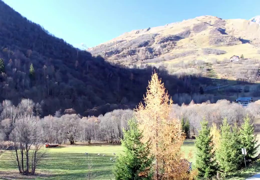

In [ ]:
Image.fromarray(img_original.astype(np.uint8))

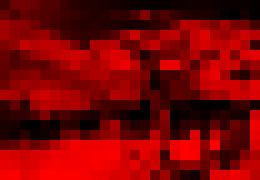

In [ ]:
Image.fromarray(img_original_RGB_red_shades.astype(np.uint8))

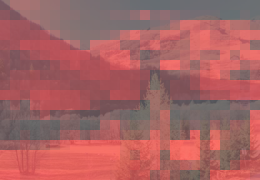

In [ ]:
# We add an alpha layer to the original picture with a 100/255 transparency ratio
img_original_alpha = np.zeros((180, 260, 4), dtype=np.uint8)
img_original_alpha[:, :, 0:3] = img_original
img_original_alpha[:, :, 3] = 100

# We add an alpha layer to the red shades picture with a 200/255 transparency ratio
img_original_RGB_red_shades_alpha = np.zeros((180, 260, 4), dtype=np.uint8)
img_original_RGB_red_shades_alpha[:, :, 0:3] = img_original_RGB_red_shades
img_original_RGB_red_shades_alpha[:, :, 3] = 200

# We combine the two pictures and display the output
background = Image.fromarray(img_original_alpha)
foreground = Image.fromarray(img_original_RGB_red_shades_alpha)
background.paste(foreground, (0, 0), foreground)
background


# Use of skimage

In [ ]:
import skimage.io
import skimage.segmentation

23
CPU times: user 1.18 s, sys: 4.06 ms, total: 1.19 s
Wall time: 1.19 s


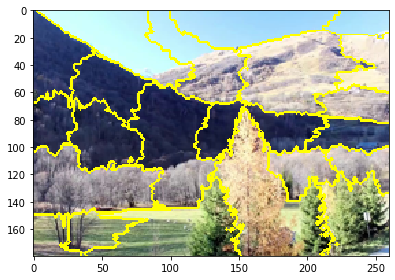

In [ ]:
%%time
img_original_01 = img_original / 255
segments = skimage.segmentation.quickshift(img_original_01, kernel_size=5, max_dist=50, ratio=0.5)
num_segments = np.unique(segments).shape[0]
print(num_segments)

skimage.io.imshow(skimage.segmentation.mark_boundaries(img_original_01, segments));
